## FHT with qubit

We will use this example to better understand how we can compute the FPT. The idea is simple, under either homodyne or photon counting, can we compute the FHT for the system to undergo some kind of evolution. We will not focus on the clock example initially, but will come back to it in detail.

Here we will assume that the system is evolving under some Lindblad equation 
\begin{equation}
    \frac{d\rho}{dt} = \mathcal{L}(\rho)\,.
\end{equation}
When computing the first hitting time, we want to define a subspace of the Hilbert space that is an absorbing boundary condition. In this sense, whenever the state $\rho$ has a non-zero overlap with this subspace, some probability is lost. This is very similar to having absorbing boundary conditions in say the heat equation.
Let us define a projector onto this subspace as $\mathcal{M}(\rho) = \Lambda \rho \Lambda^{\dagger}$ which satisfies $\sum_{i} \Lambda^{\dagger}\Lambda = \mathbb{I}$.
The probability at any given time that the state is in this subspace is given by $P(\Lambda) = {\rm Tr} [\Lambda^{\dagger}\Lambda\rho]$.
Thus, at each time-step, if the wave function has any non-zero overlap with this subspace we want to remove it from the subspace. 
To to this, we can define the unnormalised density matrix 
\begin{equation}
    \frac{d\tilde{\rho}}{dt} = \mathcal{L}(\tilde{\rho}) - \mathcal{M}(\tilde{\rho})\,,
\end{equation}
where the probability that at time $t$, the state is still hasn't "hit" the subspace is given by $P(\sim\Lambda) = {\rm Tr}[\tilde{\rho}]$, where we have used the notation $\sim \Lambda$ to indicate not in the subspace. 
Clearly, this probability evolves according to the differential equation
\begin{equation}
    \frac{d P(\sim \Lambda)}{dt} = - {\rm Tr}[\mathcal{M}(\tilde{\rho})]\,,
\end{equation}
Thererfore, we know that what Gardiner calls $G(x,t)$ in his notes is equivalent to our $P(\sim \Lambda)$, and what he calls $\partial_{t} G(x,t)$ is equivalent to $\dot{P}(\sim \Lambda)$.
Moreover, the the FHT is therefore given by $\bar{t} = -\int_{0}^{\infty}dt \partial_{t}G(x, t) t$ which in our case is given by 
\begin{equation}
    \bar{t} = \int_{0}^{\infty} dt {\rm Tr}[\mathcal{M}(\tilde{\rho})] t 
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import trapz
from time import time
from tqdm import tqdm

plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({'font.size': 24})

from jupyterthemes import jtplot
# jtplot.style()
jtplot.style(theme='grade3')


def tilted_liouvillian(H, L, chi, v):
    '''
    Compute the tilted liouvillian for a single jump operator

    Parameters
    ----------
    H : qobj
        The Hamiltonian of the system
    L : qobj
        The jump operator
    chi : float 
        The value of the counting field
    v : float
        The value of the counting field

    Returns
    -------
    L_tilt : qobj
        The tilted liouvillian
    '''
    
    # Only works for one jump operator
    L_vec = liouvillian(H, [L])
    L_tilt = L_vec + 1j*chi * ( spre(L) + spost(L.dag()) ) - (chi**2 / (2))
    
    return L_tilt

# We can pass this tilted liouvillian to the mesolve function
def solve_tilted_liouvillian(H, L, chi_list, rho0, t, dt):
    '''

    Solve the Titlted Liouvillian for a single operator using mesolve

    Parameters
    ----------
    H : qobj
        The Hamiltonian of the system
    L : qobj
        The jump operator
    chi_list : list
        The list of chi values for the counting field
    v : float
        The value of the counting field
    rho0 : qobj
        The initial state of the system
    t : list
        The time list   
    
    Returns
    -------
    pchis : list
        The list of pchi values for each chi value as a function of time 
    '''
    
    # Vectorize the initial state
    rho_ss_vec = operator_to_vector(rho0)

    # Initialize the list of pchi values
    pchis = np.zeros((len(chi_list), len(t)), dtype=complex)

    # Loop over the chi values
    liouvs = [tilted_liouvillian(H, L, i, 1) for i in tqdm(chi_list, desc="Computing tilted liouvillians")]

    # Loop over the chi values and times 
    for i in tqdm(range(len(chi_list)), desc="Computing pchi values"):

        L_i = (liouvs[i]*dt).expm()
        rho_temp = rho_ss_vec
        for j, t_j in enumerate(t):

            rho_new = L_i * rho_temp
            pchis[i, j] = vector_to_operator(rho_new).tr()
            rho_temp = rho_new

    return pchis

In [2]:
# Create some useful fuctions
def catch(xei, xr):
    
    # Catch instances where min isn't met
    
    try:
        return np.min(np.where(np.real(xei)>=xr))
    except ValueError:
        return -1

# Define function for jumpy operators
def jump_ops(m_ops, method='PD'):

    if method == 'PD':
        L1 = [to_super(m_op) for m_op in m_ops]
        
    elif method == 'Homodyne':
         L1 = [spre(m_op) + spost(m_op.dag()) for m_op in m_ops]
    else:
        raise NameError("Check method. It should be 'PD' or 'Homodyne', not: {} ".format(method))

    return L1
    

In [3]:
# Define system parameters
k = 0.5
Ω = 1

# useful operators
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sm = sigmam()
sp = sigmap()

# ground state and excited states
ground = fock_dm(2, 0)
excited = fock_dm(2, 1)

ground_vec = operator_to_vector(ground)
excited_vec = operator_to_vector(excited)

# Create time list for average and stochastic
t0 = 0
t1 = 25
dt = 0.005
t1s = 25
dts = 0.005
t = np.arange(t0, t1, dt)
ts = np.arange(t0, t1s, dts)

## As a start, focus on the Waiting time distribution for jumps

Let's first consider a simple example of a driven qubit given by the Hamiltonian 
\begin{equation}
    H = \frac{\Omega}{2}\sigma_{x}
\end{equation}
which is subject to spontaneous emission $L = \sqrt{\gamma} \sigma_{-}$. Let us define the subspace as the first time that the particle undergoes a jump, that is $\mathcal{M}(\rho) = \sigma_{-}\rho \sigma_{+}$. 
In this model we can define the following quantities:
1. The probability that at a time $t$ they system hasn't undergone a jump is $P(\sim jump, t) = {\rm Tr}[\tilde{\rho}]$.
2. The probability that at the given time $t$ the the a jump will occur $P(jump|t) =\gamma {\rm Tr}[\sigma_{+} \sigma_{-}\tilde{\rho}]$, sometimes called the waiting time distribution.

Note these two are very different. The first asks the probability that after time $t$ has not occured. It's negation states, that what is the probability that at time $t$ what is the probability that a jump has occured, is not the same as the waiting time distribution because we do not care when the jump occured, only that it did occur. 
Moreover, it is clear that $-P(jump | t) = \dot{P}(\sim jump, t)$ from the definition given at the start, which means that $G(jump, t) = -P(jump | t)$, which is the well known result.

In [4]:
# Define dissipator
L = np.sqrt(k)*sm
c_ops = [L]

# Define system Hamiltonian
H = (Ω/2)*sx

# Define steadystate and convert to vector
rho_ss = steadystate(H, c_ops)
rho_ss_vec = operator_to_vector(rho_ss)

def H_eff_super(H, G):
    # Effective Hamiltonian in super form
    return -1j*(spre(H) - spost(H)) - 0.5*(spre(G) + spost(G)) 

J0 = jump_ops(c_ops)[0]
L0 = liouvillian(H, c_ops) - J0
rho0t = mesolve(L0, rho_ss, t, [], []).states

In [5]:
# Compute Pxt distribution as a function of time
P0t = np.array([np.abs(rhoi.tr()) for rhoi in rho0t])

# Waiting time distribution (Gabriel)
waiting = np.array([expect(L.dag()*L, rhoi) for rhoi in rho0t])
P1t_d = np.array([expect(excited, rhoi) for rhoi in rho0t])

# Following Gardiners description compute G0t
G0t = -np.gradient(P0t)/dt

# Compute mean jump time 
tbar = sum(G0t * t)*dt

# This seems right
print('integral of G(jump, t) =', np.sum(G0t)*dt)

integral of G(jump, t) = 0.9987085044170588


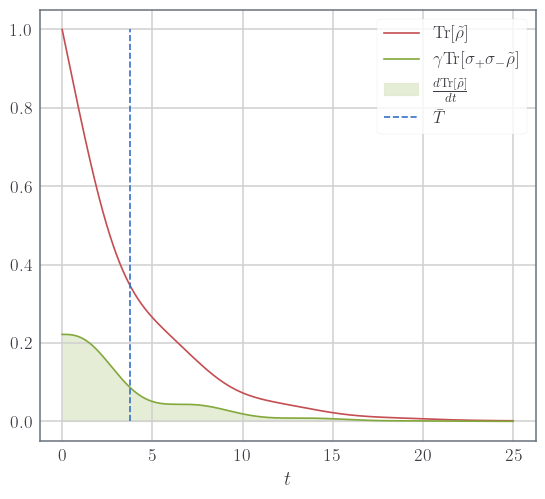

In [6]:
plt.plot(t, P0t, 'r', label=r'${\rm Tr}[\tilde{\rho}]$')
plt.plot(t, waiting, 'g', label=r'$\gamma {\rm Tr}[\sigma_{+}\sigma_{-}\tilde{\rho}]$')
plt.fill_between(t, G0t, alpha=0.2, color='g', label=r'$\frac{d{\rm Tr}[\tilde{\rho}]}{dt}$')
plt.vlines(tbar, 0, 1, color='b', linestyle='--', label=r'$\bar{T}$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

In [7]:
# opts_stoch = Options(store_all_expect=True)
ntraj = 1000
results = photocurrent_mesolve(H, rho_ss, ts, sc_ops=[L], e_ops=[excited], ntraj=ntraj, store_measurement=True)

# Get photocurrent signal
measurments = (np.array(results.measurement)*dts).astype('int').T[0]

10.0%. Run time:   1.90s. Est. time left: 00:00:00:17
20.0%. Run time:   3.80s. Est. time left: 00:00:00:15
30.0%. Run time:   5.69s. Est. time left: 00:00:00:13
40.0%. Run time:   7.60s. Est. time left: 00:00:00:11
50.0%. Run time:   9.61s. Est. time left: 00:00:00:09
60.0%. Run time:  11.54s. Est. time left: 00:00:00:07
70.0%. Run time:  13.54s. Est. time left: 00:00:00:05
80.0%. Run time:  15.47s. Est. time left: 00:00:00:03
90.0%. Run time:  17.38s. Est. time left: 00:00:00:01
Total run time:  19.30s


/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_79978/1122606903.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  measurments = (np.array(results.measurement)*dts).astype('int').T[0]


In [8]:
def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None
    

# Get first hitting indices    
inds = np.array([get_first_hit(mi, 1) for mi in measurments.T])
inds = inds[inds != None]

# Get first hitting times
hitting_times = ts[list(inds)]

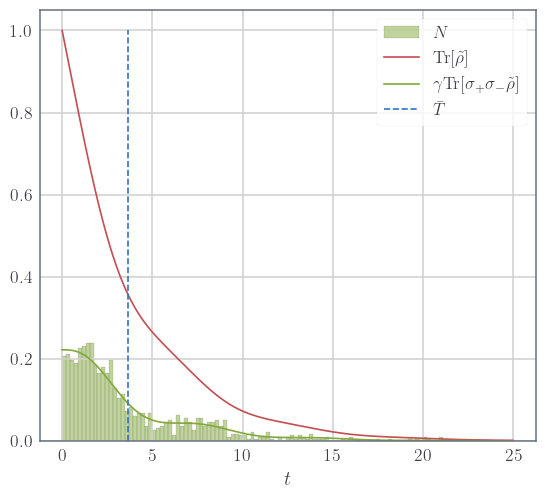

In [9]:
fig = plt.figure()

plt.hist(hitting_times, density=True, bins=100, color='g', alpha=0.5, edgecolor='k', label=r'$N$')
plt.plot(t, P0t, 'r', label=r'${\rm Tr}[\tilde{\rho}]$')
plt.plot(t, waiting, 'g', label=r'$\gamma {\rm Tr}[\sigma_{+}\sigma_{-}\tilde{\rho}]$')
plt.vlines(np.mean(hitting_times), 0, 1, color='b', linestyle='--', label=r'$\bar{T}$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

plt.show()

# fig.savefig('Waiting_time.png', dpi=200, bbox_inches='tight')

## Now study Homodyne current

So the waiting time distribution is a relatively easy concept to define, but what about something from the homodyne current? 

In [10]:
# opts_stoch = Options(store_all_expect=True)
ntraj = 2000
results_homodyne = smesolve(H, rho_ss, ts, sc_ops=[1j*L], e_ops=[excited, sx, sy], ntraj=ntraj, store_all_expect=True, store_measurement=True)

10.0%. Run time:   7.99s. Est. time left: 00:00:01:11
20.0%. Run time:  16.02s. Est. time left: 00:00:01:04
30.0%. Run time:  24.01s. Est. time left: 00:00:00:56
40.0%. Run time:  31.97s. Est. time left: 00:00:00:47
50.0%. Run time:  40.09s. Est. time left: 00:00:00:40
60.0%. Run time:  48.24s. Est. time left: 00:00:00:32
70.0%. Run time:  56.26s. Est. time left: 00:00:00:24
80.0%. Run time:  64.20s. Est. time left: 00:00:00:16
90.0%. Run time:  72.19s. Est. time left: 00:00:00:08
Total run time:  80.12s


In [11]:
# Study the integrated current over time of sy 
sy_expect = np.real(np.array(results_homodyne.runs_expect))[:, 2, :]
sy_integrate = np.cumsum(sy_expect, axis=1)*dts

# Get Homodyne signal
homodyne =  np.real(np.array(results_homodyne.measurement)).astype('float32').T[0]
homodyne_integrate = np.cumsum(homodyne, axis=0)*dts

So we can clearly see that there is a fininte probability that the signal can decrease in time, which means this is not a time-homogenous process.

It further indicates that this time process can decrease in time. This means, that if we naievely take $\mathcal{L} - \mathcal{H}$, then we will get negative values in $G(t)$

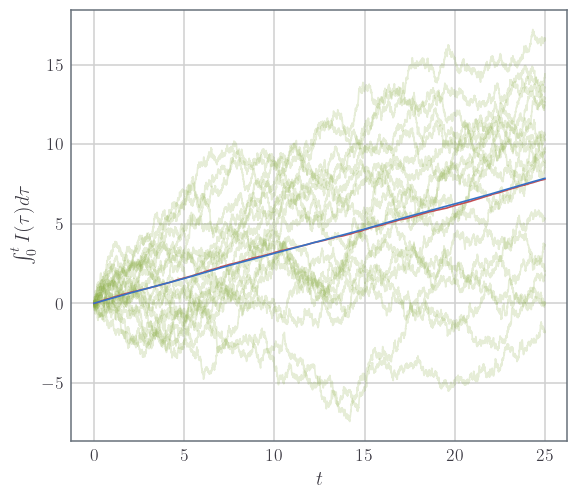

In [12]:
fig = plt.figure()
plt.plot(ts, homodyne_integrate[:, :20], color='g', alpha=0.2)
plt.plot(ts, np.mean(homodyne_integrate, axis=1), color='r', label=r'$\langle \sigma_{y} \rangle_{H}$')
plt.plot(t, np.sqrt(k)*np.mean(sy_integrate, axis=0), color='b', label=r'$\langle \sigma_{y} \rangle_{I}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$ \int_{0}^{t} I(\tau)d\tau $')

plt.show()
# fig.savefig('Integrated_current.png', dpi=200, bbox_inches='tight')

In [13]:
# Get hitting times of homodyne dynamics
nmin = 1
inds_homodyne = np.array([get_first_hit(mi, nmin) for mi in homodyne_integrate.T])
inds_homodyne = inds_homodyne[inds_homodyne != None]

# Get first hitting times for homodyne
hitting_times_homodyne = ts[list(inds_homodyne)]
mean_hitting_time_homodyne_sim = np.mean(hitting_times_homodyne)

# Here we will study the tilted Liouvillian

In [14]:
# Create chi space and compute tilted Liouvillians
dchi = 0.005
chi = np.arange(-30, 30, dchi)

# Creatte time space
dtimes = 0.01
times = np.arange(0.0, 20, dtimes)

# Compute tilted Liouvillians
pchis = solve_tilted_liouvillian(H, 1j*L, chi, rho_ss, times, dtimes)

Computing pchi values: 100%|██████████| 12000/12000 [1:50:38<00:00,  1.81it/s]    


In [15]:
# Now compute integral over n = 1
dn = 0.1
nvals = np.arange(-20, 20, dn)
Pnt = np.real(np.array([trapz(np.exp(-1j*ni*chi)*pchis.T, chi, dx=dchi, axis=1)/(2*np.pi) for ni in nvals]))*dn

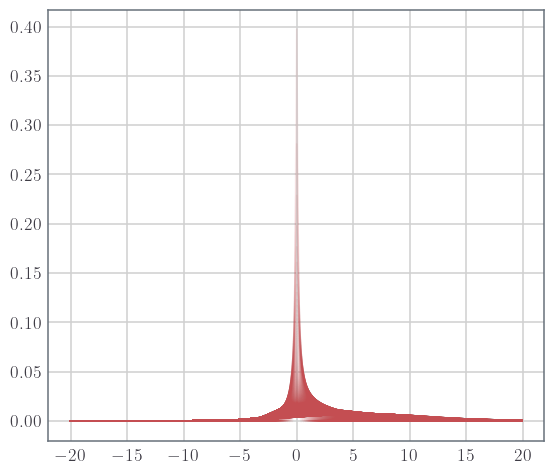

In [16]:
plt.plot(nvals, Pnt, color='r', alpha=0.1)

# plt.ylim(-0.5,0.5)
plt.show()

In [17]:
Pnt_less_1 = Pnt.copy()
Pnt_less_1[nvals > 1] = 0
P1t = np.sum(Pnt_less_1, axis=0)

# Compute G0t and mean hitting time
dG0t_hom_tilted = -np.gradient(P1t)/dtimes

mean_hitting_time_homodyne_tilted = np.sum(times*dG0t_hom_tilted)*dtimes

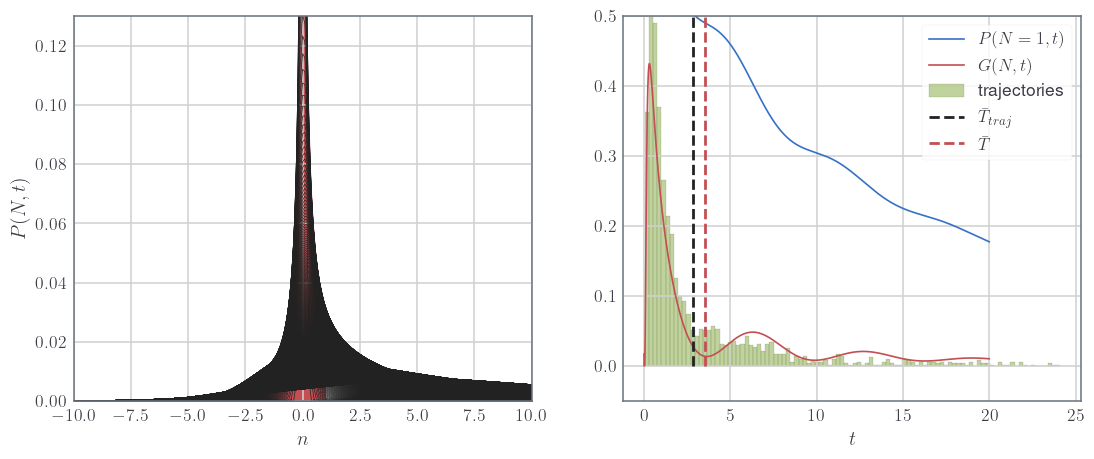

In [18]:
# Plot the results of Pnt vs nvals

fig = plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
for Pnt_fill in Pnt_less_1.T:
    plt.fill_between(nvals, Pnt_fill, color='r', alpha=0.2)

plt.plot(nvals, Pnt, color='k', linewidth=0.5)
plt.ylim(0, 0.13)
plt.xlim(-10, 10)

plt.xlabel(r'$n$')
plt.ylabel(r'$P(N, t)$')

plt.subplot(1, 2, 2)
plt.plot(times, P1t, color='b', label=r'$P(N=1, t)$')
plt.plot(times, dG0t_hom_tilted, color='r', label=r'$G(N,t)$')
plt.hist(hitting_times_homodyne, bins=100, density=True, alpha=0.5, edgecolor='k', color='g', label=r'trajectories')

plt.vlines(mean_hitting_time_homodyne_sim, 0, 1, color='k', linestyle='--', linewidth=2, label =r'$\bar{T}_{traj}$')
plt.vlines(mean_hitting_time_homodyne_tilted, 0, 1, color='r', linestyle='--', linewidth=2, label=r'$\bar{T}$')

plt.xlabel(r'$t$')
plt.ylim(-0.05, 0.5)
plt.legend()

plt.show()

# fig.savefig('Pnt_vs_nvals_hom.png', dpi=300, bbox_inches='tight')

In [ ]:
mean_hitting_time_homodyne_sim

In [ ]:
np.sum(P1t)*dtimes

In [ ]:
sy

In [ ]:
sp